In [1]:

import re
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import sklearn
from scipy.sparse import vstack
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, auc, classification_report, roc_curve
from sklearn.model_selection import (
    # LearningCurveDisplay,
    # learning_curve,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics._dist_metrics import DistanceMetric
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [6]:
# adata -> output of preprocessing (in theory)
file = "/home/jkuhn/Bachelors-Thesis/input/CountAdded_PIP_global_object_for_cellxgene1.h5ad"
adata_all = sc.read_h5ad(file)
adata_all.var_names_make_unique()
adata_all

AnnData object with n_obs × n_vars = 329762 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

# One hot encoding

In [7]:
encoder_organ = LabelEncoder()
y_encoded = encoder_organ.fit_transform(adata_all.obs["Organ"])  # encode the organ labels

In [8]:
# Replace the existing 'Organ' column with the encoded labels
adata_all.obs["Organ"] = y_encoded

In [9]:
label_table = pd.DataFrame(
    {
        "Encoded_Label": encoder_organ.transform(encoder_organ.classes_),
        "Decoded_Label": encoder_organ.classes_,
    }
)

# Print the table
print(label_table)

    Encoded_Label Decoded_Label
0               0           BLD
1               1           BMA
2               2           CAE
3               3           DUO
4               4           ILE
5               5        JEJEPI
6               6         JEJLP
7               7           LIV
8               8           LLN
9               9           LNG
10             10           MLN
11             11           OME
12             12           SCL
13             13           SKM
14             14           SPL
15             15           TCL
16             16           THY


### Subsetting the dataset: 

In [10]:
celltype = "B cells"

In [11]:
adata = adata_all[(adata_all.obs["Majority_voting_CellTypist_high"] == celltype)]

In [12]:
adata

View of AnnData object with n_obs × n_vars = 45802 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [13]:
# split for each chem and organ for this celltype into train and test
def ttsplit(celltype: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    count = 0

    subset_celltype = adata[(adata.obs["Majority_voting_CellTypist_high"] == celltype)]

    for chem in subset_celltype.obs["Chemistry"].unique():
        subset_chemistry = subset_celltype[
                (subset_celltype.obs["Chemistry"] == chem)
            ]

        for organ in subset_chemistry.obs["Organ"].unique(): 

            subset_organ = subset_chemistry[(subset_chemistry.obs["Organ"] == organ)]
            X = subset_organ.to_df()
            y = subset_organ.obs["Organ"]
            subset_name = f"{celltype}_{organ}_{chem}"
    
            try:
                if count != 0:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])
                    count = count + 1

                else:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )
                    count = count + 1

            except ValueError as e:

                num_elements = X.shape[0]

                if num_elements == 1:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = X, None, y, None

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])

                else:
                    print(f"Subset with name '{subset_name}' caused an error: {e}")

                continue
    return X_train, X_test, y_train, y_test

In [14]:
def save_model(bst: xgb.Booster, modelname: str):
    print("modelname: " + model_name)
    bst.save_model(model_name)

In [16]:
def load_model(modelname: str) -> xgb.Booster:
    bst = xgb.Booster()
    bst.load_model(modelname)
    return bst

In [18]:
def prediction(bst: xgb.Booster) -> pd.DataFrame: # gets model and returns classification report, y_pred_encoded oder adata mit prediction
    y_pred_prob = bst.predict(dtest) # predict
    y_pred_encoded = np.argmax(y_pred_prob, axis =1)

    accuracy = accuracy_score(y_test, y_pred_encoded)
    print(f"Accuracy: {accuracy}")
    
    y_test_decoded = encoder_organ.inverse_transform(
        y_test
    ) 
    y_pred_encoded_series = pd.Series(y_pred_encoded)

    # Map the encoded labels to decoded labels using the label table DataFrame
    y_pred = y_pred_encoded_series.map(
        dict(zip(label_table["Encoded_Label"], label_table["Decoded_Label"]))
    )

    class_report = metrics.classification_report(y_test, y_pred_encoded)

    print("Classification Report for celltype: ", celltype)
    print(class_report)

    with open(report_name, "a") as f:
        print("Classification Report for celltype:", celltype, file=f)
        print(class_report, file=f)

    result_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_encoded})

    actual_counts = result_df["Actual"].value_counts()
    predicted_counts = result_df["Predicted"].value_counts()
    combined_counts = pd.concat([actual_counts, predicted_counts], axis=1)
    combined_counts.columns = ["Actual", "Predicted"]
    combined_counts = combined_counts.fillna(0)  # Fill NaN values with 0

    # Plot the distributions
    combined_counts.plot(kind="bar", figsize=(12, 6))
    plt.title("Distribution of Actual and Predicted Categories for " + celltype)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted"])
    plt.show()

    return y_pred_encoded

In [19]:
X_train, X_test, y_train, y_test = ttsplit(celltype) # returns X_train,...
X = adata.to_df()
y = adata.obs["Organ"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
num_classes = len(encoder_organ.classes_)
print("Number of classes:", num_classes)
class_names = encoder_organ.classes_
model_number = "0005"
report_name = f"{model_number}_classification_report.txt"

Number of classes: 17


# Parameter Tuning
Here, the following tutorial was adapted: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [21]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    "num_class": num_classes,
    # Other parameters
    "objective": "multi:softprob",
    "eval_metric": ['merror','mlogloss'], 
    'device': 'cuda'
}

### Parameters num_boost_round and early_stopping_rounds

In [22]:
# train model with that
evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    evals_result = evals_result
)
print("Best merror: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[16:24:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	train-merror:0.31590	train-mlogloss:1.71733	eval-merror:0.34307	eval-mlogloss:1.74763
[1]	train-merror:0.28445	train-mlogloss:1.41310	eval-merror:0.31778	eval-mlogloss:1.46623
[2]	train-merror:0.26266	train-mlogloss:1.20898	eval-merror:0.30274	eval-mlogloss:1.28011
[3]	train-merror:0.24475	train-mlogloss:1.06023	eval-merror:0.29314	eval-mlogloss:1.14823
[4]	train-merror:0.23088	train-mlogloss:0.94427	eval-merror:0.28399	eval-mlogloss:1.04646
[5]	train-merror:0.21835	train-mlogloss:0.85263	eval-merror:0.27494	eval-mlogloss:0.96881
[6]	train-merror:0.20667	train-mlogloss:0.77976	eval-merror:0.27036	eval-mlogloss:0.90895
[7]	train-merror:0.19400	train-mlogloss:0.71709	eval-merror:0.26436	eval-mlogloss:0.85881
[8]	train-merror:0.18428	train-mlogloss:0.66646	eval-merror:0.26098	eval-mlogloss:0.82000
[9]	train-merror:0.17434	train-mlogloss:0.62025	eval-merror:0.25630	eval-mlogloss:0.78600
[10]	train-merror:0.16582	train-mlogloss:0.58165	eval-merror:0.25466	eval-mlogloss:0.75847
[11]	trai

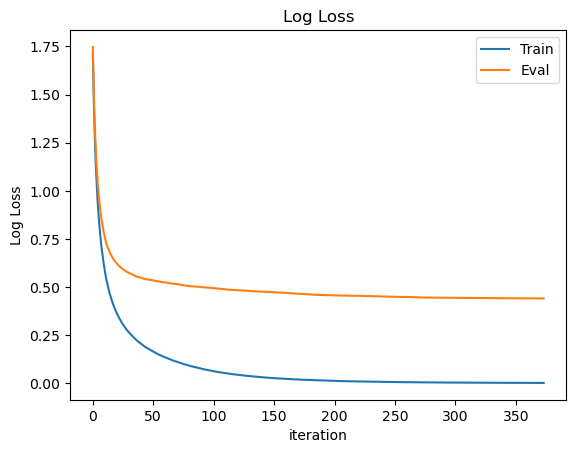

In [23]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

# Log-Loss
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['eval']['mlogloss'], label='Eval')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('iteration')
plt.title('Log Loss')
plt.show()

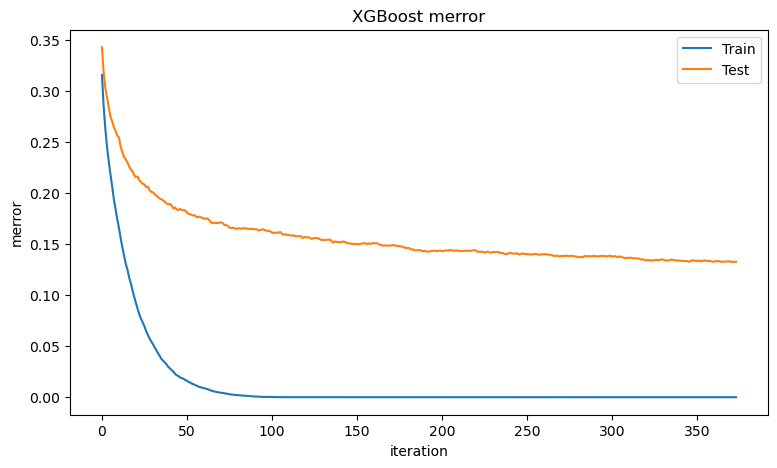

In [24]:
# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, evals_result['train']['merror'], label='Train')
ax.plot(x_axis, evals_result['eval']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.xlabel('iteration')
plt.title('XGBoost merror')
plt.show()

In [25]:
# saving that 
evals_result = {}

num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    evals_result = evals_result
)

[20:40:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	Test-merror:0.34307	Test-mlogloss:1.74763
[1]	Test-merror:0.31778	Test-mlogloss:1.46623
[2]	Test-merror:0.30274	Test-mlogloss:1.28011
[3]	Test-merror:0.29314	Test-mlogloss:1.14823
[4]	Test-merror:0.28399	Test-mlogloss:1.04646
[5]	Test-merror:0.27494	Test-mlogloss:0.96881
[6]	Test-merror:0.27036	Test-mlogloss:0.90895
[7]	Test-merror:0.26436	Test-mlogloss:0.85881
[8]	Test-merror:0.26098	Test-mlogloss:0.82000
[9]	Test-merror:0.25630	Test-mlogloss:0.78600
[10]	Test-merror:0.25466	Test-mlogloss:0.75847
[11]	Test-merror:0.24518	Test-mlogloss:0.73055
[12]	Test-merror:0.24005	Test-mlogloss:0.71154
[13]	Test-merror:0.23547	Test-mlogloss:0.69530
[14]	Test-merror:0.23308	Test-mlogloss:0.68064
[15]	Test-merror:0.23013	Test-mlogloss:0.66796
[16]	Test-merror:0.22632	Test-mlogloss:0.65613
[17]	Test-merror:0.22305	Test-mlogloss:0.64463
[18]	Test-merror:0.22141	Test-mlogloss:0.63595
[19]	Test-merror:0.21749	Test-mlogloss:0.62841
[20]	Test-merror:0.21563	Test-mlogloss:0.62087
[21]	Test-merror:0.2164

In [26]:
best_model.save_model("bestB_softprob.model")

[00:36:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [21]:
# use model later: 
loaded_model = xgb.Booster()
loaded_model.load_model("Models/bestB_softprob.model")

training done
Accuracy: 0.8668919655510738
Classification Report for celltype:  B cells
              precision    recall  f1-score   support

           0       0.90      0.46      0.61        80
           1       0.86      0.56      0.68       299
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.92      0.41      0.56        27
           5       0.00      0.00      0.00        23
           6       1.00      0.15      0.26        20
           7       0.96      0.64      0.77        84
           8       0.86      0.89      0.87      3019
           9       0.50      0.02      0.04        48
          10       0.81      0.74      0.77      1087
          11       1.00      0.64      0.78        22
          12       0.33      0.11      0.17         9
          13       1.00      0.25      0.40        12
          14       0.89      0.94      0.91      4417
          15       0.50      0.11      0.18    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


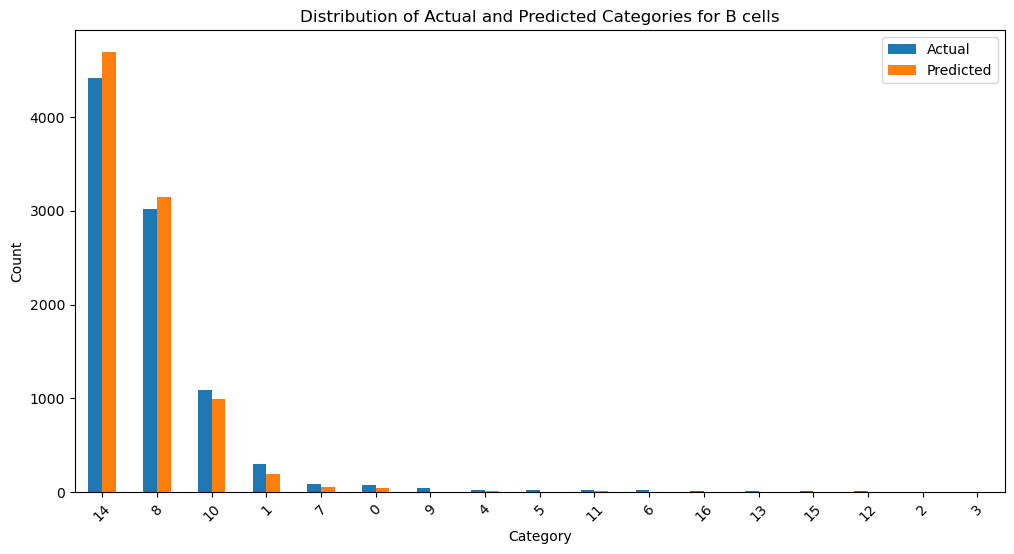

SCORE: 0.8668919655510738


In [22]:
print("training done")
y_pred_encoded = prediction(loaded_model)
y_pred_prob = loaded_model.predict(dtest)
y_pred_encoded = np.argmax(y_pred_prob, axis =1)

accuracy = accuracy_score(y_test, y_pred_encoded)
print ("SCORE:", accuracy)

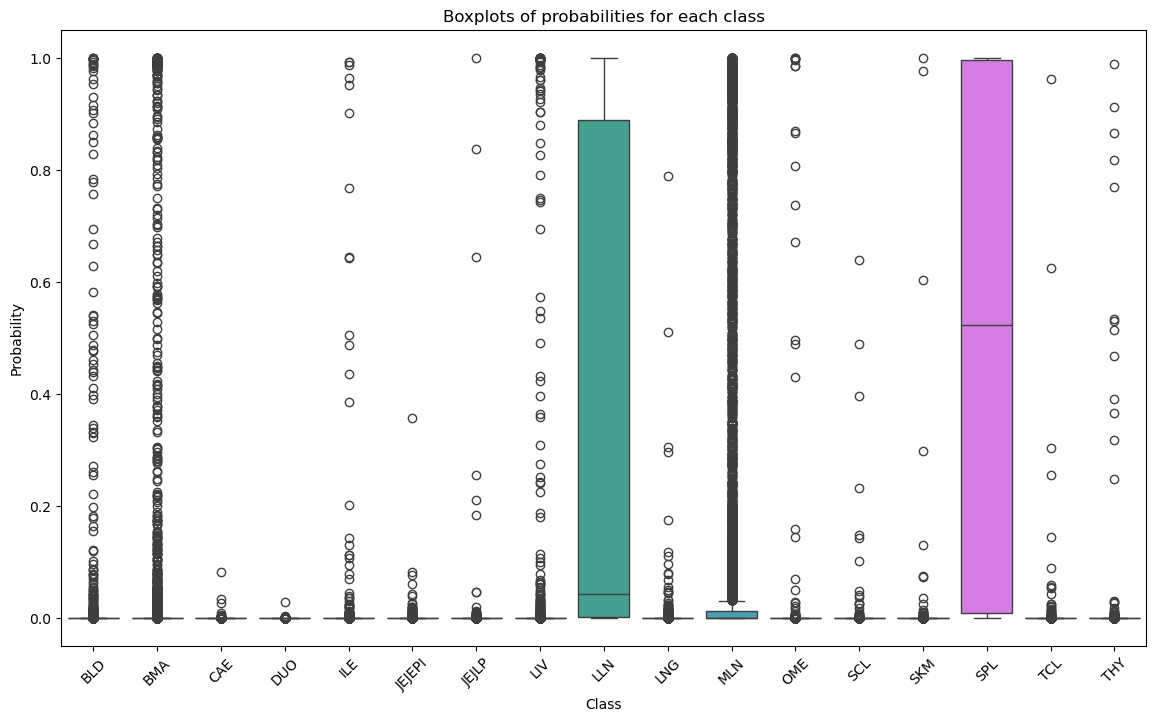

In [30]:
# Convert class indices to class labels for the DataFrame columns
class_labels = label_table['Decoded_Label'].tolist()
df = pd.DataFrame(y_pred_prob, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

## Apply on Exercise Dataset

In [31]:
file = "adata_final.h5ad"
print("reading file")
adata2 = sc.read_h5ad(file)
modelname = "B cells"

reading file


In [32]:
bst = xgb.Booster()
bst.load_model("bestB_softprob.model")

In [33]:
subset = adata2[(adata2.obs["celltypist_cell_label_coarse"] == "B cells")]
X = subset.to_df()
deval = xgb.DMatrix(X) 

In [34]:
y_pred_prob_ex = loaded_model.predict(deval) # predict
predictions = np.argmax(y_pred_prob_ex, axis =1)

In [35]:
label_mapping = {
            0: 'BLD',
            1: 'BMA',
            2: 'CAE',
            3: 'DUO',
            4: 'ILE',
            5: 'JEJEPI',
            6: 'JEJLP',
            7: 'LIV',
            8: 'LLN',
            9: 'LNG',
            10: 'MLN',
            11: 'OME',
            12: 'SCL',
            13: 'SKM',
            14: 'SPL',
            15: 'TCL',
            16: 'THY'
}

In [36]:
# Add predictions to the subset
subset.obs["Predicted_tissue"] = [label_mapping[int(pred)] for pred in predictions]
subset.obs["celltype_model"] = modelname

Trying to modify attribute `.obs` of view, initializing view as actual.


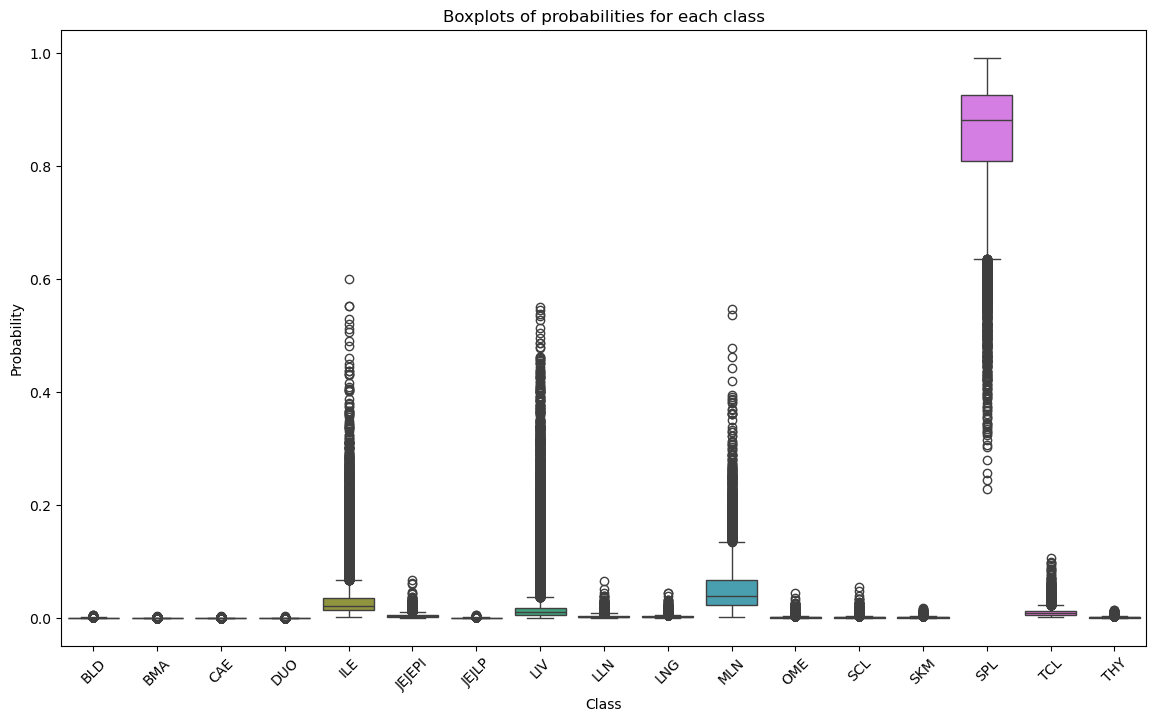

In [37]:
# Convert class indices to class labels for the DataFrame columns
class_labels = [label_mapping[i] for i in range(y_pred_prob_ex.shape[1])]
df = pd.DataFrame(y_pred_prob_ex, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

In [40]:
# Extract 'timepoint' and 'Predicted_tissue' columns
data = {
    'timepoint': subset.obs['timepoint'],
    'Predicted_tissue': subset.obs['Predicted_tissue']
}
df = pd.DataFrame(data)

df = pd.DataFrame(data)

# Group by timepoint and calculate predicted tissue value counts for each timepoint
predicted_tissue_counts_by_timepoint = df.groupby('timepoint')['Predicted_tissue'].value_counts()

# Print the predicted tissue value counts for each timepoint
for timepoint, counts in predicted_tissue_counts_by_timepoint.groupby(level=0):
    print(f"Timepoint {timepoint}:")
    for tissue, count in counts.items():
        print(f"{tissue}\t{count}")
    print()


Timepoint 5b:
('5b', 'SPL')	3846
('5b', 'LIV')	7
('5b', 'ILE')	6
('5b', 'MLN')	1

Timepoint 5a:
('5a', 'SPL')	3399
('5a', 'LIV')	9
('5a', 'ILE')	4
('5a', 'MLN')	1

Timepoint 30a:
('30a', 'SPL')	3568
('30a', 'LIV')	12
('30a', 'ILE')	3
('30a', 'MLN')	1

Timepoint 120a:
('120a', 'SPL')	63
('120a', 'ILE')	0
('120a', 'LIV')	0
('120a', 'MLN')	0

